In [117]:
# importing Libraries

import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from plotly.offline import iplot
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.models import save_model, load_model

In [121]:
# Reading the sample data
df = pd.read_csv("sample_data.csv")

In [122]:
df.head()

,text,label
0,zucker fabrik,ft
1,Lebensmittel kommssionierung,ft
2,geländer biegen,mr
3,gebäudeausrüstung technische,ct
4,kürbiskernöl softgels,ft


In [123]:
df.label.value_counts(normalize=True)*100

ft     30.181476
pkg    25.855626
ct     13.606668
mr     13.485684
ch      9.915311
cnc     6.955236
Name: label, dtype: float64

In [124]:
df.isnull().sum()

text       0
label    100
dtype: int64

## Preprocessing 

In [125]:
def remove_unwanted(text):
    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    
    return text

def remove_special_characters(text):
    # Define a regular expression pattern to match non-German letters, digits, and whitespace
    pattern = re.compile(r'[^a-zA-ZäöüßÄÖÜ0-9\s]')
    # Use the pattern to replace non-matching characters with an empty string
    cleaned_text = pattern.sub('', text)
    
    return cleaned_text

def preprocess_german_text(text):
    text = text.lower()
    # Tokenization
    tokens = word_tokenize(text, language='german')
    # Removal of stopwords
    stop_words = set(stopwords.words('german'))
    tokens = [token for token in tokens if token.lower() not in stop_words]
    # Stemming
    stemmer = SnowballStemmer('german')
    # Filter out single letters if they are standalone tokens
    tokens = [stemmer.stem(token) if len(token) > 1 else token for token in tokens]
    
    return ' '.join(tokens)

In [126]:
def preprocess(df, column):
    df[column] = df[column].apply(remove_unwanted)
    df[column] = df[column].apply(remove_special_characters)
    df[column] = df[column].apply(preprocess_german_text)
    df[column] = df[column].str.strip()
    df.loc[df['text'].apply(lambda x: len(preprocess_german_text(x)) <= 1), 'text'] = np.nan
    for col in df.columns:
        df[col] = df[col].replace(r'^\s*$', np.nan, regex=True)
    df.fillna({'text': 'OTHERS'}, inplace=True)
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    return df

In [127]:
data = preprocess(df, 'text')

In [128]:
data.head()

,text,label
0,zuck fabrik,ft
1,lebensmittel kommssionier,ft
2,geland bieg,mr
3,gebaudeausrust technisch,ct
4,kurbiskernol softgel,ft


In [129]:
data.isnull().sum()

text     0
label    0
dtype: int64

## Training

In [130]:
max_words_in_each_row = data['text'].apply(lambda x: len(str(x).split())).max()

# Now, max_words_in_each_row will contain the maximum number of words in each row
print(max_words_in_each_row)

62


In [134]:
from collections import Counter

text_column = df['text']

all_text = ' '.join(text_column.astype(str))

words = all_text.split()

# Calculated word frequencies
word_frequencies = Counter(words)

# Find the most common word and its frequency
most_common_word, frequency = word_frequencies.most_common(1)[0]

print(f"The most frequent word is: {most_common_word} with frequency: {frequency}")


The most frequent word is: verpack with frequency: 1476


In [135]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 1250
# Max number of words in each text.
MAX_SEQUENCE_LENGTH = 75
EMBEDDING_DIM = 100

In [136]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True)
tokenizer.fit_on_texts(data['text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 17140 unique tokens.


In [96]:
### Create a Pickle file for mapping
import pickle
token_pickle = open("tokenizer.pkl","wb")
pickle.dump(tokenizer, token_pickle)
token_pickle.close()

In [86]:
X = tokenizer.texts_to_sequences(data['text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (37195, 75)


In [87]:
# Output label
Y = pd.get_dummies(data['label']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (37195, 6)


In [88]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.15, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(31615, 75) (31615, 6)
(5580, 75) (5580, 6)


In [90]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(75, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(6, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 75, 100)           125000    
                                                                 
 spatial_dropout1d_6 (Spatia  (None, 75, 100)          0         
 lDropout1D)                                                     
                                                                 
 lstm_6 (LSTM)               (None, 75)                52800     
                                                                 
 dense_6 (Dense)             (None, 6)                 456       
                                                                 
Total params: 178,256
Trainable params: 178,256
Non-trainable params: 0
_________________________________________________________________
None


In [91]:
epochs = 5
batch_size = 64

class_labels = np.unique(Y_train.argmax(axis=1))
class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=Y_train.argmax(axis=1))
class_weight_dict = dict(zip(class_labels, class_weights))

history = model.fit(X_train, 
                    Y_train, 
                    epochs=epochs, 
                    batch_size=batch_size,
                    validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)], 
                    class_weight=class_weight_dict)

Epoch 1/5
445/445 [==============================] - 35s 77ms/step - loss: 0.9148 - accuracy: 0.6911 - val_loss: 0.4855 - val_accuracy: 0.8134
Epoch 2/5
445/445 [==============================] - 35s 78ms/step - loss: 0.4870 - accuracy: 0.8149 - val_loss: 0.4803 - val_accuracy: 0.8052
Epoch 3/5
445/445 [==============================] - 35s 79ms/step - loss: 0.4588 - accuracy: 0.8218 - val_loss: 0.4675 - val_accuracy: 0.8065
Epoch 4/5
445/445 [==============================] - 35s 79ms/step - loss: 0.4464 - accuracy: 0.8235 - val_loss: 0.4727 - val_accuracy: 0.8106
Epoch 5/5
445/445 [==============================] - 35s 79ms/step - loss: 0.4380 - accuracy: 0.8238 - val_loss: 0.4635 - val_accuracy: 0.8061


In [92]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

175/175 [==============================] - 1s 7ms/step - loss: 0.4900 - accuracy: 0.8043
Test set
  Loss: 0.490
  Accuracy: 0.804


In [93]:
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Decode one-hot encoded labels to original labels
y_test_labels = np.argmax(Y_test, axis=1)

# Print the classification report
print("Classification Report:\n", classification_report(y_test_labels, y_pred))

175/175 [==============================] - 1s 7ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.79      0.82       532
           1       0.34      0.91      0.50       385
           2       0.94      0.80      0.86       770
           3       0.94      0.82      0.88      1728
           4       0.83      0.74      0.78       743
           5       0.92      0.79      0.85      1422

    accuracy                           0.80      5580
   macro avg       0.81      0.81      0.78      5580
weighted avg       0.87      0.80      0.82      5580



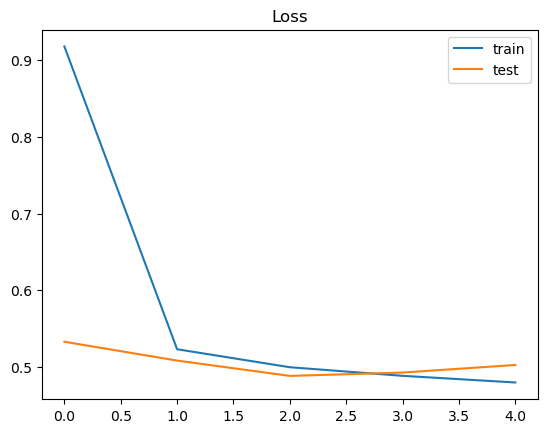

In [26]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

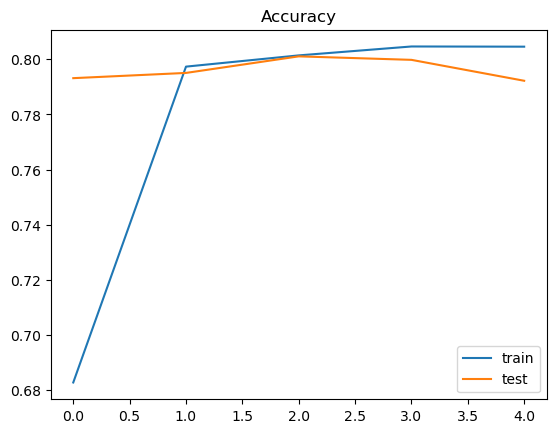

In [27]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [100]:
# Save the trained model
model.save('LSTM_model.h5')

In [104]:
new = load_model('LSTM_model.h5')

In [105]:
y_pred_pr = new.predict(X_test)
y_pred_new = np.argmax(y_pred_pr, axis=1)

# Decode one-hot encoded labels to original labels
y_test_la = np.argmax(Y_test, axis=1)

# Print the classification report
print("Classification Report:\n", classification_report(y_test_la, y_pred_new))

175/175 [==============================] - 1s 7ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.79      0.82       532
           1       0.34      0.91      0.50       385
           2       0.94      0.80      0.86       770
           3       0.94      0.82      0.88      1728
           4       0.83      0.74      0.78       743
           5       0.92      0.79      0.85      1422

    accuracy                           0.80      5580
   macro avg       0.81      0.81      0.78      5580
weighted avg       0.87      0.80      0.82      5580

